<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Verification_by_abstraction_with_eran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with ERAN

---

*This tutorial gives an overview of the features of ERAN. \\
"ETH Robustness Analyzer for Neural Networks (ERAN) is a state-of-the-art sound, precise, scalable, and extensible analyzer based on abstract interpretation for the complete and incomplete verification". \\
First, we will use the example of a neural network trained on the IRIS dataset to show how abstract verification can be performed using zonotopes. For this purpose, a network is first trained on the data, then saved in ONNX format and then verified with ERAN. \\
Second, we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset.*

Important Links:
- [ERANs Github Repo](https://github.com/eth-sri/eran)
- [ERANs documentation](https://files.sri.inf.ethz.ch/eran/docs/eran_manual.pdf)

---

**This is a interactive tutorials. So feel free to experiment and change stuff. In every spot we think it would be intersting to change some stuff around we put this little icon.**

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

---

![img](https://raw.githubusercontent.com/eth-sri/eran/master/overview.png)

# Preperation

First we have to prepare our working environment. This takes around 7 minutes.

If you want to, you can take the time to look at the therotical background for abstract verification in this [book](https://arxiv.org/pdf/2109.10317.pdf). It gives an introductions into different forms of verification of neural networks. The chapter 9 explains the basics of zonotope abstraction, which is used in this tutorial.

## Installation

First we need to install some required packages. \\
(We are using a fork of ERAN here, because of a bug in their code. This will change in the future, should the bug be fixed)

In [ ]:
%%capture
%%bash

git clone https://github.com/DDiekmann/eran.git

sudo apt install m4
sudo apt install build-essential
sudo apt install autoconf
sudo apt install libtool
sudo apt install texlive-latex-base

cd eran
sudo bash ./install.sh
pip install -r requirements.txt
pip install onnx onnxruntime

## Imports

Next we need to import the required libraries.

In [133]:
%%capture

import torch
from torch import nn
import numpy as np
import torch.onnx
import sys

import matplotlib.pyplot as plt

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}
import mnist_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py'}
import plots

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/zonotpy/main/src/zonotope.py'}
from zonotope import zono

# Training of a simple neural network

In this section we will first define a neural network and train it on the [IRIS dataset](https://archive.ics.uci.edu/ml/datasets/iris). This will be saved in ONNX format.

## Definition of the Neural Network
We define a network with one linear layer and ReLU as activation function. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Training
The model is then trained on the iris dataset.

In [123]:
names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=10), 
    epochs=200, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 200/200 [00:00<00:00, 645.04it/s]


Done. Accuracy: 0.8333333333333334


## Visualization
The plots below show the ground truth values and the classification made by the network on the data. 

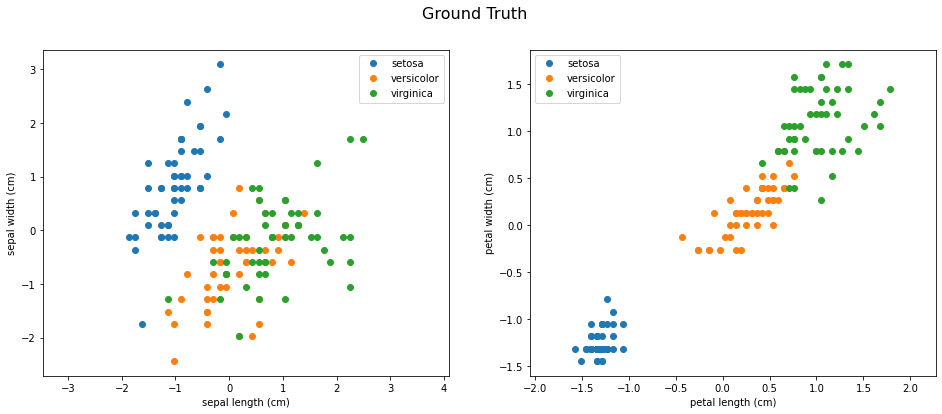

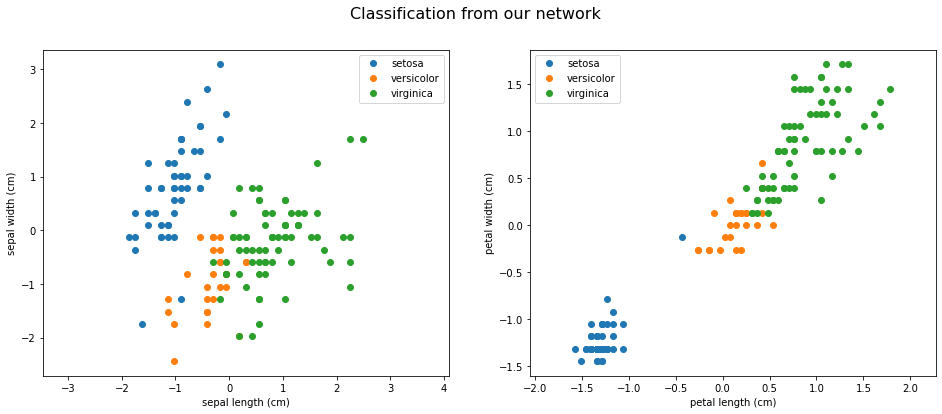

In [124]:
plots.show_plots(names, feature_names, X_scaled, y, title = 'Ground Truth')
plots.show_plots(names, feature_names, X_scaled, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

## Save the network
The network is then exported to a ONNX file.

In [125]:
model_filename = "iris_net.onnx"
dummy_input=torch.randn(1, 4)

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['data'],
                  output_names=['classification'],
                  )

# Verifications with Zonotope Abstraction

In the next steps we define a zonotope for abstract verification of the network with ERAN.
The verification will then be performed using ERAN on the network with the defined zonotope.

## Definition of the zonotope
In order to use ERAN on a custom dataset and network, one needs to define the zonotope used in abstract verification. \
For an explanation on zonotopes see for example this [website](https://mitadmissions.org/blogs/entry/what-is-a-zonotope/). \
As described in the [manual of ERAN](https://files.sri.inf.ethz.ch/eran/docs/eran_manual.pdf), "the zonotope file
has two integers followed by a number of floats. The numbers can be separated by spaces, commas, or newlines. The first integer denotes the input dimension (e.g. 784 for MNIST).
The second integer is one plus the number of error terms of the zonotope. The number of floats is the two integers multiplied. Looking at an input of $i = [x0, x1, ... , xk]$, the file has all $\alpha$ values of the affine forms following each other."

We first want a small zonotope surrounding a point in the dataset. The chance, that we can successfully verify the robustness of the network here is probably high. \
Therefore, we take the first value of X and Y:

In [57]:
print(X_scaled[0])
print(y[0])

[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
0


As we can see, the input values are roughly $[-0.9, 1.02, -1.34, -1.32]$. The classification label for that input is $0$. If we visualize this in the graph of our ground truth data, we can see, that there is some space around it, which should only be classified as 'setosa'. 

*The point is marked by the red cross.*

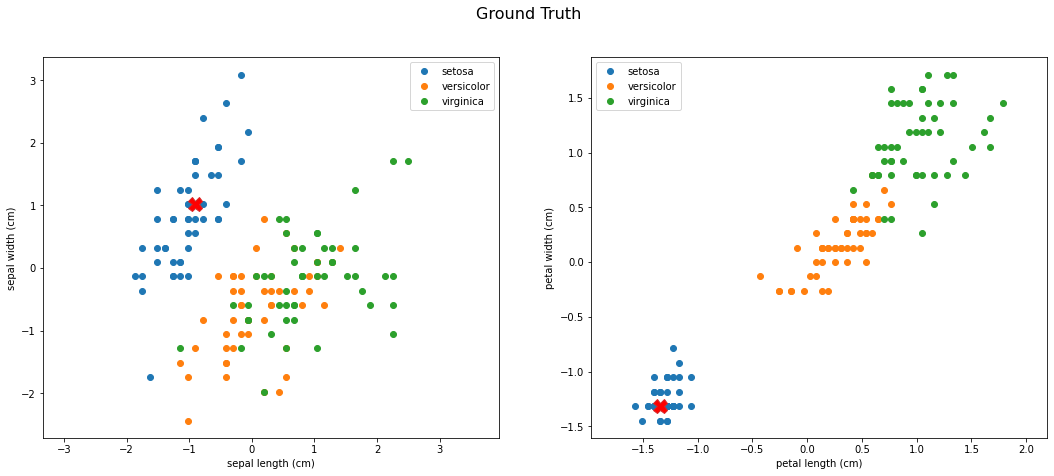

In [59]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

plots.show_plots(names, feature_names, X_scaled, y, title = 'Ground Truth', fig=fig, ax1= ax[0], ax2=ax[1])
ax[0].plot(X_scaled[0][0], X_scaled[0][1], marker="X", markersize=14, markerfacecolor="red")
ax[1].plot(X_scaled[0][2], X_scaled[0][3], marker="X", markersize=14, markerfacecolor="red")

We now describe our zonotope. If you are not familiar with zonotope description with generators you can find some information in this [book](https://arxiv.org/pdf/2109.10317.pdf) in chapter 9. 

**Lets start with a really small zonotope. Which is defined as follows:** 

In [161]:
%%writefile small_zonotope_example.txt
4
3
-0.90068117 0.03 0.0 
1.01900435 0.0 0.03 
-1.34022653  0.03 0.0 
-1.3154443  0.0 0.03

Overwriting small_zonotope_example.txt


This zonotpe creates a 4 dimensional cube, which is hard to look at for us humans. But we can view at in the already seen graphs.For this we have to zoom in a lot, because the zonotope is very small.

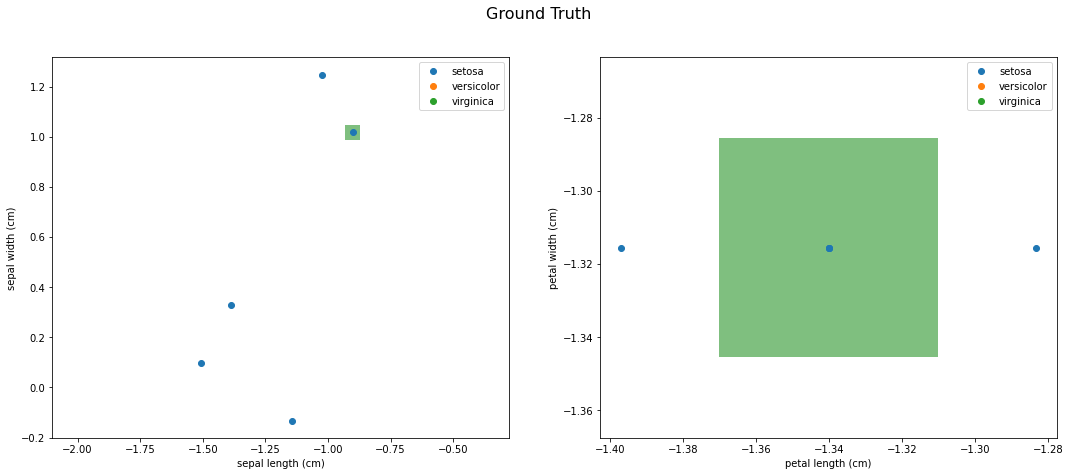

In [165]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

plots.show_plots(names, feature_names, X_scaled[:5], y[:5], title = 'Ground Truth', fig=fig, ax1= ax[0], ax2=ax[1])

z = zono.from_file("small_zonotope_example.txt")
z1, z2 = z.split()
z1.visualize(shape = True, fig=fig, ax=ax[0])
z2.visualize(shape = True, fig=fig, ax=ax[1])

## Abstract verification with ERAN
Now we can run the verificator of ERAN on the model with use of the defined zonotope. 

For this follwing parameters have to be provided:
* --netname : the location of the onnx file 
* --zonotope : the location of the zonotope file we just created 
* --domain : which domain should be used (we use the domain 'deepzono', if you want to have a look at other domains, the manual will help you) 

In [162]:
%%bash
cd eran/tf_verify/

python3 . --netname ../../iris_net.onnx --zonotope ../../small_zonotope_example.txt --domain deepzono

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': False,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../iris_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../small_zonotope_example.txt'}
netname  ../../iris_net.on

2022-07-20 09:05:51.502059: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


The verifcation returns multiple pieces of information.

First we can see, for our input zonotope robustness could be verified. In addition we are given the nlb (lower bound) and nub (upper bound) of our output zonotope.

Because the lower bound in our first dimension is higher than the upper bounds in the second and third dimension, our network will classify all points in our input zonotope as 'setosa'. This is what we expected.

But what if we make it bigger? 😲


## Another zonotope
In the next step, we select the same point as before as the centre of the zonotope, but make the zonotope significantly larger. What can we expect from the verification? 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

In [169]:
%%writefile big_zonotope_example.txt
4
3
-0.90068117 2 0.0 
1.01900435 0.0 2 
-1.34022653 2 0.0 
-1.3154443 0.0 2

Overwriting big_zonotope_example.txt


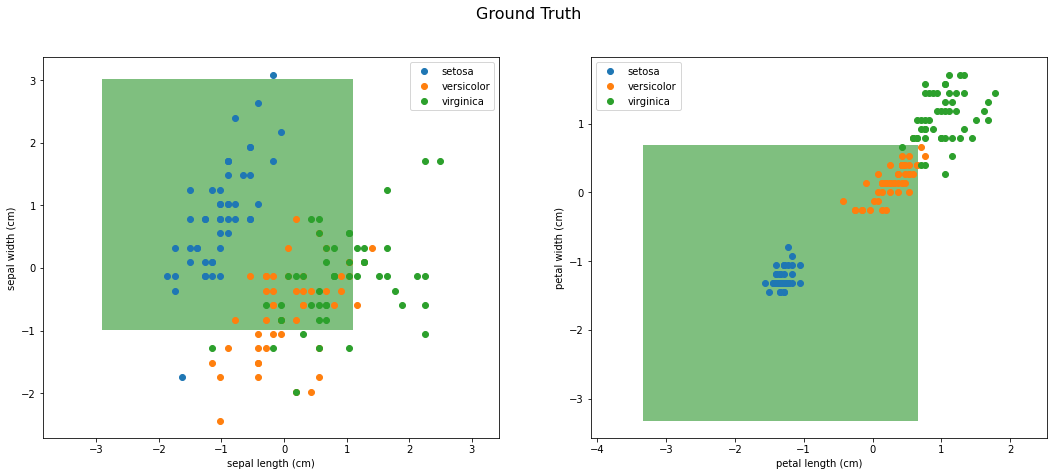

In [170]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

plots.show_plots(names, feature_names, X_scaled, y, title = 'Ground Truth', fig=fig, ax1= ax[0], ax2=ax[1])

z = zono.from_file("big_zonotope_example.txt")
z1, z2 = z.split()
z1.visualize(shape = True, fig=fig, ax=ax[0])
z2.visualize(shape = True, fig=fig, ax=ax[1])

In [171]:
%%bash
cd eran/tf_verify/

python3 . --netname ../../iris_net.onnx --zonotope ../../big_zonotope_example.txt --domain deepzono --debug true 

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': True,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../iris_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../big_zonotope_example.txt'}
netname  ../../iris_net.onnx 

2022-07-20 09:09:16.859430: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


As we can see, the robustness of the network could not be verified with a larger zonotope. 

Maybe you can find some more examples and that way investigate the robustness of this very small network.

# Verification of a bit more complex neural network

## Definition of the Neural Network

We define a network with one linear layer and ReLU as activation function. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

In [134]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Training
The model is then trained on the mnist dataset.

In [135]:
train_dataloader, test_dataloader = mnist_trainer.load_mnist_dataset(batch_size=64)

model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64
Epoch 1
-------------------------------


100%|██████████| 938/938 [00:08<00:00, 107.67it/s]


Test Error: 
 Accuracy: 91.6%, Avg loss: 0.281524 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:07<00:00, 120.18it/s]


Test Error: 
 Accuracy: 92.9%, Avg loss: 0.234127 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:07<00:00, 120.96it/s]


Test Error: 
 Accuracy: 93.8%, Avg loss: 0.206818 

Done!


## Save the network
The network is then, like before exported as a ONNX file.

In [138]:
model_filename = "mnist_net.onnx"
dummy_input=torch.randn(1, 28, 28)

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['image'],
                  output_names=['classification'],
                  )

## Verification

Another Options Eran gives us it to simply aplly an epsilon (infinity norm) value for the robustness verification. *You can have a look into our Tutorials for SMT Based Verifications for a deeper look into the usage of an epsilon.*

For this follwing parameters have to be provided:
* --netname : the location of the onnx file 
* --epsilon : our epsilon 
* --domain : which domain should be used (we use the domain 'deepzono', if you want to have a look at other domains, the manual will help you)
* --dataset : the dataset on which we the training data is based on (Eran provides three different datasets) 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/Edit_icon_%28the_Noun_Project_30184%29.svg/1024px-Edit_icon_%28the_Noun_Project_30184%29.svg.png" alt="drawing" width="50"/>

In [140]:
%%bash

cd eran/tf_verify/

python3 . --netname ../../mnist_net.onnx --epsilon 0.03 --domain deepzono --dataset mnist

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': 'mnist',
 'debug': False,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0.03,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../mnist_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': None}
netname  ../../mnist_net.onnx  epsilon  0.03  dom

2022-07-20 08:24:18.226920: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")


The verifcation returns multiple pieces of information.

First we can see, that from 100 tested input images only 97 where correctly predicted by our network, wich is to be expected with a accurcy of roughly 93%.

Of these 97 only 62 could be verified to be robust in the are defined by our epsilon.

---

If we are more interested in a specific area of the input space, we could create a zonotope. But with 178 input variables this can be a hard task.

We just use one that is provided. If you want to hav a look at it, you cant print the first 50 lines by commenting out the "%%capture".

In [149]:
%%capture
!wget --no-cache --backups=1 {'https://github.com/eth-sri/eran/files/3653882/zonotope_example.txt'}

with open("zonotope_example.txt") as myfile:
    head = [next(myfile) for x in range(100)]
for l in head:
  print(l)

Now we can run the verificator of ERAN on the model with use of the defined zonotope, like we have seen before.

In [150]:
%%bash
cd eran/tf_verify/

python3 . --netname ../../mnist_net.onnx --zonotope ../../zonotope_example.txt --domain deepzono

{'approx_k': True,
 'attack': False,
 'complete': False,
 'data_dir': None,
 'dataset': None,
 'debug': False,
 'delta': 0.3,
 'domain': 'deepzono',
 'epsfile': None,
 'epsilon': 0,
 'from_test': 0,
 'gamma': inf,
 'geometric': False,
 'geometric_config': None,
 'input_box': None,
 'k': 3,
 'logdir': None,
 'logname': None,
 'max_milp_neurons': 30,
 'mean': None,
 'n_milp_refine': 1,
 'netname': '../../mnist_net.onnx',
 'normalized_region': True,
 'num_params': 0,
 'num_tests': None,
 'numproc': 2,
 'output_constraints': None,
 'partial_milp': 0,
 'quant_step': None,
 'refine_neurons': False,
 's': -2,
 'sparse_n': 70,
 'spatial': False,
 'specnumber': None,
 'std': None,
 'subset': None,
 't_norm': 'inf',
 'target': None,
 'timeout_complete': None,
 'timeout_final_lp': 100,
 'timeout_final_milp': 100,
 'timeout_lp': 1,
 'timeout_milp': 1,
 'use_default_heuristic': True,
 'use_milp': True,
 'vnn_lib_spec': None,
 'zonotope': '../../zonotope_example.txt'}
netname  ../../mnist_net.onnx  

2022-07-20 08:41:43.934077: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
./optimizer.py:26: UserWarning: gpupoly not available.
  warnings.warn("gpupoly not available.")
